# ch04.02 UNet-Image segmentation

* 날짜: 2022.08.04
* 이름: 윤태우

## 학습내용
    - Image multiclass segmentation에 대해 이해한다.
    - 이미지 분절 작업을 수행한다.

## Muticlass Segmenation



<p  align='center'>
<img src ='https://miro.medium.com/max/1400/1*B16t8Do6hvuq2Q_2YOM-UQ.png' width=500>
</p>


<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0402-01.PNG?raw=true' width=800>
</p>


In [191]:
! git clone https://github.com/karolzak/keras-unet

fatal: destination path 'keras-unet' already exists and is not an empty directory.


In [192]:
import sys, os, glob
sys.path.append('/content/keras-unet')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import utils, callbacks, models, layers
from keras_unet.models import custom_unet

## 데이터셋: Crowd Instance-level Human Parsing (CIHP)
---

(https://arxiv.org/abs/1811.12596)

* 38,280개의 다양한 인간 이미지
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/chip.png?raw=true)

In [193]:
# 데이터셋
!gdown https://drive.google.com/u/4/uc?id=10p_-JQ8T7EuOJ1AWLSQpkUcrIhtRJgK_&export=download

Downloading...
From: https://drive.google.com/u/4/uc?id=10p_-JQ8T7EuOJ1AWLSQpkUcrIhtRJgK_
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:31<00:00, 93.5MB/s]


In [194]:
!unzip -q instance-level-human-parsing.zip

replace ICCV15_fashion_dataset(ATR)/humanparsing/JPEGImages/2500_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace ICCV15_fashion_dataset(ATR)/humanparsing/JPEGImages/2500_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 데이터 전처리

In [213]:
# Training / Validation / Test
data_dir = '/content/instance-level_human_parsing/instance-level_human_parsing/'
train_img_paths = sorted(glob.glob(f'{data_dir}/Training/Images/*'))
train_mask_paths = sorted(glob.glob(f'{data_dir}/Training/Category_ids/*'))

valid_img_paths = sorted(glob.glob(f'{data_dir}/Validation/Images/*'))
valid_mask_paths = sorted(glob.glob(f'{data_dir}/Validation/Category_ids/*'))
print(len(train_img_paths), train_img_paths[0])
print(len(train_mask_paths), train_mask_paths[0])
print(len(valid_img_paths), valid_img_paths[0])
print(len(valid_mask_paths), valid_mask_paths[0])

28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Images/0000006.jpg
28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Category_ids/0000006.png
5000 /content/instance-level_human_parsing/instance-level_human_parsing//Validation/Images/0000001.jpg
5000 /content/instance-level_human_parsing/instance-level_human_parsing//Validation/Category_ids/0000001.png


In [214]:
# # 이거는 좀 더 안전한 방법
# train_img_paths = [mask_path.replace('png', 'jpg') for mask_path in train_mask_paths]
# train_img_paths = [img_path.replace('Category_ids', 'Images') for img_path in train_img_paths]

# print(len(train_img_paths), train_img_paths[0])

### 첫번째 이슈 : 넘파이 배열로 데이터를 저장하기 무리가 있다.

In [215]:
imgs = []
masks = []
for img_path, mask_path in zip(train_img_paths[:10], train_mask_paths[:10]):
  # path2img
  img = Image.open(img_path).resize( (128,128) )
  img = np.array(img)
  imgs.append(img)
  # path2mask
  mask = Image.open(mask_path).resize( (128,128) )
  mask = np.array(mask)
  masks.append(mask)
imgs = np.asarray(imgs)
masks = np.asarray(masks)
masks = np.expand_dims(masks, 3)

imgs.shape, masks.shape

((10, 128, 128, 3), (10, 128, 128, 1))

In [216]:
len(train_img_paths)

28280

In [217]:
# for 루프 대신에 map을 사용
# map에 들어갈 함수 특징: 리스트가 아니라 scalar 를 받는다.
def path2tensor(image_path, mask_path, IMAGE_SIZE=128): # 이미지 경로 한개, 마스크 경로 한개
  # 이미지 처리
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=3)
  image.set_shape([None, None, 3])
  image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  image = image / 255.

  # 마스크 처리
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask.set_shape([None, None, 1])
  mask = tf.image.resize(images=mask, size=[IMAGE_SIZE, IMAGE_SIZE])
  return image, mask

def aug(image, mask) :
  # 랜덤 밝기 -> 이미지만
  image = tf.image.random_brightness(image, 0.2)
  # 랜덤 대비 -> 이미지만
  image = tf.image.random_contrast(image, 0.2,0.5)

  # 이미지-마스크 같이 변환
  stacked = tf.concat([image, mask], axis = 2)
  # 랜덤 좌우 반전 -> 이미지, 마스크
  stacked = tf.image.random_flip_left_right(image, seed = 1)
  # 랜덤 상하 반전
  stacked = tf.image.random_flip_up_down(stacked, seed =1)
  image = stacked[:,:,:3]
  mask = tf.reshape(stacked[:,:,-1], (128,128,1))
  return image,mask

(TensorShape([128, 128, 3]), TensorShape([128, 128, 1]))

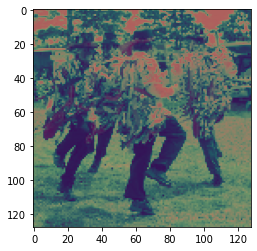

In [218]:
img, mask = path2tensor(train_img_paths[2], train_mask_paths[2])
img,mask = aug(img, mask)
plt.imshow(img);plt.imshow(mask[:,:,0], alpha=.3, cmap='rainbow')
img.shape, mask.shape

In [219]:
train_ds = tf.data.Dataset.from_tensor_slices((train_img_paths, train_mask_paths))
train_ds = train_ds.map(path2tensor, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(aug)
train_ds = train_ds.batch(32, drop_remainder=True)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_mask_paths))
valid_ds = valid_ds.map(path2tensor, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(32, drop_remainder=True)

print(train_ds)
print(valid_ds)

<BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.float32, name=None))>


### 두번째 이슈 : 플로팅 다시 

In [220]:
for imgs, masks in train_ds.take(1):
  print(imgs.shape, masks.shape)
  N = 10
  plt.subplot(121);_=plt.hist(tf.reshape(imgs, [-1]))
  plt.subplot(122);_=plt.hist(tf.reshape(masks, [-1]))
  plt.show()
  for img, mask in zip(imgs[:N], masks[:N]):
    plt.figure(figsize=(11,4))
    plt.subplot(131);plt.imshow(img);plt.xticks([]);plt.yticks([])
    plt.subplot(132);plt.imshow(img);plt.imshow(mask[:,:,0], alpha=.5, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(133);plt.imshow(mask[:,:,0], cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 모델 준비
--- 

In [ ]:
model = custom_unet((128,128,3),
                    num_classes=20,
                    filters=32, 
                    output_activation='softmax',
                    )
model.summary()

In [233]:
# 컴파일
def iou(y_true, y_pred, smooth=1.):
  from tensorflow.keras import backend as K
  true_f = K.flatten(true)
  pred_f = K.flatten(pred)
  intersection = K.sum(true_f * pred_f)
  iou_score = (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
  score.append(iou_score)
  
  return sum(score) / len(score)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = [tf.keras.metrics.OneHotMeanIoU(20)])

In [230]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [234]:
ckp = callbacks.ModelCheckpoint(filepath = 'model.h5',
                                save_best_only = True,
                                monitor = 'val_iou')
tb = callbacks.TensorBoard(log_dir = 'my_log_dir', histogram_freq = 5)

histroy = model.fit(train_ds, epochs = 50,
                    validation_data = valid_ds,
                    callbacks=[ckp,tb])

Epoch 1/50
883/883 [==============================] - ETA: 0s - loss: 0.4272 - one_hot_mean_io_u_1: 0.0484WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 164s 183ms/step - loss: 0.4272 - one_hot_mean_io_u_1: 0.0484 - val_loss: 3.2621 - val_one_hot_mean_io_u_1: 1.0000
Epoch 2/50
883/883 [==============================] - ETA: 0s - loss: 0.0184 - one_hot_mean_io_u_1: 0.1109WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 159s 180ms/step - loss: 0.0184 - one_hot_mean_io_u_1: 0.1109 - val_loss: 3.7832 - val_one_hot_mean_io_u_1: 0.5000
Epoch 3/50
883/883 [==============================] - ETA: 0s - loss: 0.0153 - one_hot_mean_io_u_1: 0.1663WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 159s 180ms/step - loss: 0.0153 - one_hot_mean_io_u_1: 0.1663 - val_loss: 4.1097 - val_one_hot_mean_io_u_1: 1.0000
Epoch 4/50
883/883 [==============================] - ETA: 0s - loss: 0.0161 - one_hot_mean_io_u_1: 0.0997WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 160s 181ms/step - loss: 0.0161 - one_hot_mean_io_u_1: 0.0997 - val_loss: 4.5375 - val_one_hot_mean_io_u_1: 0.5000
Epoch 5/50
883/883 [==============================] - ETA: 0s - loss: 0.0144 - one_hot_mean_io_u_1: 0.4989WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 160s 181ms/step - loss: 0.0144 - one_hot_mean_io_u_1: 0.4989 - val_loss: 4.8219 - val_one_hot_mean_io_u_1: 0.5000
Epoch 6/50
883/883 [==============================] - ETA: 0s - loss: 0.0157 - one_hot_mean_io_u_1: 0.3325WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 162s 183ms/step - loss: 0.0157 - one_hot_mean_io_u_1: 0.3325 - val_loss: 4.9231 - val_one_hot_mean_io_u_1: 0.5000
Epoch 7/50
883/883 [==============================] - ETA: 0s - loss: 0.0148 - one_hot_mean_io_u_1: 0.3324WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 159s 180ms/step - loss: 0.0148 - one_hot_mean_io_u_1: 0.3324 - val_loss: 5.0731 - val_one_hot_mean_io_u_1: 0.5000
Epoch 8/50
883/883 [==============================] - ETA: 0s - loss: 0.0156 - one_hot_mean_io_u_1: 0.2495WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 160s 181ms/step - loss: 0.0156 - one_hot_mean_io_u_1: 0.2495 - val_loss: 5.0394 - val_one_hot_mean_io_u_1: 0.5000
Epoch 9/50
883/883 [==============================] - ETA: 0s - loss: 0.0132 - one_hot_mean_io_u_1: 0.4987WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 160s 181ms/step - loss: 0.0132 - one_hot_mean_io_u_1: 0.4987 - val_loss: 5.2938 - val_one_hot_mean_io_u_1: 1.0000
Epoch 10/50
883/883 [==============================] - ETA: 0s - loss: 0.0133 - one_hot_mean_io_u_1: 0.2495WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 159s 180ms/step - loss: 0.0133 - one_hot_mean_io_u_1: 0.2495 - val_loss: 5.2614 - val_one_hot_mean_io_u_1: 1.0000
Epoch 11/50
883/883 [==============================] - ETA: 0s - loss: 0.0140 - one_hot_mean_io_u_1: 0.4988WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 160s 181ms/step - loss: 0.0140 - one_hot_mean_io_u_1: 0.4988 - val_loss: 5.3972 - val_one_hot_mean_io_u_1: 1.0000
Epoch 12/50
883/883 [==============================] - ETA: 0s - loss: 0.0131 - one_hot_mean_io_u_1: 0.3326WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 160s 181ms/step - loss: 0.0131 - one_hot_mean_io_u_1: 0.3326 - val_loss: 5.5013 - val_one_hot_mean_io_u_1: 1.0000
Epoch 13/50
883/883 [==============================] - ETA: 0s - loss: 0.0147 - one_hot_mean_io_u_1: 0.4987WARNING:tensorflow:Can save best model only with val_iou available, skipping.


883/883 [==============================] - 159s 180ms/step - loss: 0.0147 - one_hot_mean_io_u_1: 0.4987 - val_loss: 5.6362 - val_one_hot_mean_io_u_1: 1.0000
Epoch 14/50
692/883 [======================>.......] - ETA: 32s - loss: 0.0106 - one_hot_mean_io_u_1: 0.4989

KeyboardInterrupt: ignored

### 결과 확인

(32, 128, 128, 1) (32, 128, 128)


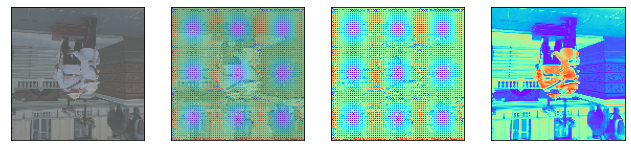

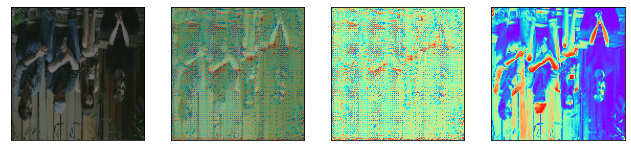

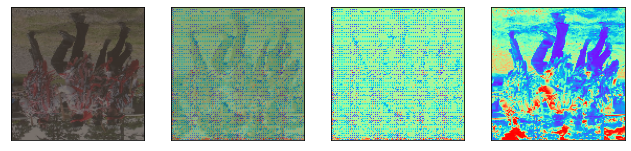

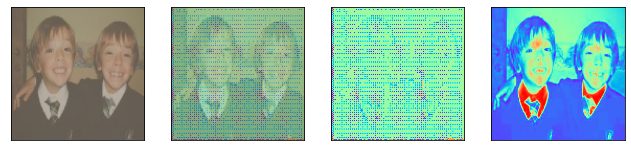

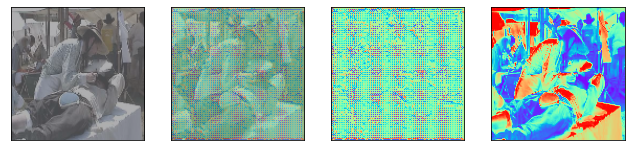

In [224]:
for imgs, masks in train_ds.take(1):
  N = 5
  preds = model.predict(imgs)
  preds = tf.argmax(preds, 3)
  print(masks.shape, preds.shape)
  for img, mask, pred in zip(imgs[:N], masks[:N], preds[:N]):
    plt.figure(figsize=(11,4))
    plt.subplot(141);plt.imshow(img);plt.xticks([]);plt.yticks([])
    plt.subplot(142);plt.imshow(img);plt.imshow(pred, alpha=.5, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(143);plt.imshow(pred, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(144);plt.imshow(mask[:,:,0], cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.show()

In [229]:
  preds = model.predict(imgs)
  preds = tf.argmax(preds, 3)
  preds

<tf.Tensor: shape=(32, 128, 128), dtype=int64, numpy=
array([[[10, 12, 12, ..., 12, 12, 12],
        [10, 16, 12, ..., 12, 12, 12],
        [17,  4, 16, ..., 16, 12, 12],
        ...,
        [ 7, 16,  3, ..., 12, 12, 12],
        [ 5,  4, 16, ..., 16, 12, 12],
        [19, 16, 16, ..., 16, 16, 16]],

       [[10, 12, 12, ..., 12, 12, 12],
        [10, 10, 17, ..., 12, 12, 12],
        [ 8,  4, 12, ..., 12, 12, 12],
        ...,
        [ 7, 10, 19, ..., 16, 18,  3],
        [ 5, 10, 16, ..., 16, 18, 12],
        [19, 16, 11, ...,  4, 16, 16]],

       [[10, 12, 12, ..., 12, 12, 12],
        [10, 16, 12, ..., 12, 12, 12],
        [ 5,  4, 12, ..., 12, 12, 12],
        ...,
        [ 5, 16, 16, ..., 12, 12, 12],
        [ 5,  4, 16, ..., 16, 12, 12],
        [19, 16, 11, ..., 16, 16, 16]],

       ...,

       [[10, 12, 12, ..., 12, 12, 12],
        [10, 16, 12, ..., 12, 12, 12],
        [17,  4, 16, ..., 12, 12, 12],
        ...,
        [15, 16, 12, ..., 12, 12, 12],
        [ 5,  4, 